<h1 align='center'>Utilizing Scientific Python Tools for the Application of Data Science Techniques to High Impact Weather Prediction</h1>
<h2 align='center'>David John Gagne II</h2>
<h3 align='center'>University of Oklahoma/National Center for Atmospheric Research</h3>
<h4 align='center'>April 13, 2015</h4>
<h4 align='center'>2015 UCAR SEA Conference</h4>

# Acknowledgements
* OU Advisor: Amy McGovern
* NCAR Advisors: Sue Haupt and John Williams
* CAPS: Ming Xue, Kevin Thomas, Chris Cook
* NOAA: Jimmy Correia, Adam Clark, Michael Coniglio
* SHARP Team: Nate Snook, Youngsun Jung, Jon Labriola
* GRAFS Team: Seth Linden, Gerry Wiener, Bill Petzke, Jared Lee


# Motivation
* High impact weather includes weather phenomena that cause large personal and/or economic losses

* Includes extreme weather disasters
    * Hurricanes, tornadoes, __hail__, floods

* Also includes "normal" weather events with economic effects
    * __Unforseen partly cloudy day causes unexpected fluctuations in solar power generation__
    * Ill-timed rainstorm delays wheat harvest
    * Mild, dry, weather closes ski resort early

#Python and Data Science in High Impact Weather Prediction
* Bridge the gap from raw numerical weather prediction model output to actionable information
    * Pre-processing model output
    * Compiling databases of historical model runs and observations
    * Applying statistical learning models to correct output and make derived products
    * Visualizing model output
    * Distributing information to users

#Interactive Demonstrations
* Hail Size Prediction
    * Locating hail swaths with image processing techniques
    * Visualizing storm-scale model output
* Solar Irradiance Prediction
    * Train statistical learning models to connect NWP model output with pyranometer observations
    * Validate skill of model predictions

#Hail Size Prediction Libraries


In [1]:
# Useful general libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
# Custom image segmentation libraries
from hail.EnhancedWatershedSegmenter import EnhancedWatershed
from hail.Hysteresis import Hysteresis
from scipy.ndimage import gaussian_filter

# Data: NOAA NSSL Multi-Radar Multi-Sensor Maximum Estimated Size of Hail

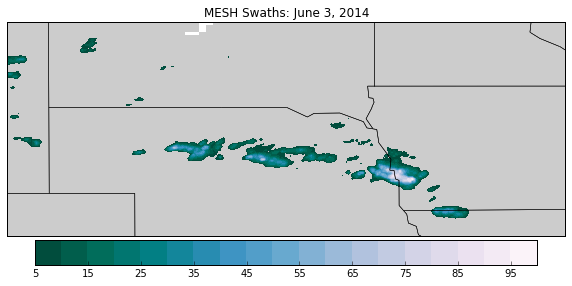

In [8]:
# Load MESH data and plot it
with Dataset("data/MESH_4km_20140603-00:00_20140603-23:00") as mesh_file:
    lon = mesh_file.variables['lon'][:]
    lat = mesh_file.variables['lat'][:]
    mesh_data = mesh_file.variables['MESH'][:]
bmap = Basemap(projection='cyl', resolution='l', 
               llcrnrlon=-105, urcrnrlon=-92,
               llcrnrlat=40, urcrnrlat=45)
plt.figure(figsize=(10,6))
bmap.drawstates()
bmap.drawlsmask()
cont = plt.contourf(lon, lat, mesh_data[22], 
             np.arange(5,105,5), cmap="PuBuGn_r")
cbar = plt.colorbar(orientation="horizontal",shrink=0.9,fraction=0.1, pad=0.01)
title_obj = plt.title("MESH Swaths: June 3, 2014")

#Image Segmentation
* Split image into distinct regions or objects based on intensity values
* Thresholding: objects are contiguous areas with intensities above a specified threshold
* Hysteresis: contiguous areas above a threshold containing at least 1 point above a second threshold
* Watershed: objects are "grown" from local maxima in layers until a minimum intensity is met
* Enhanced Watershed (Lakshmanan et al. 2009): Adds size criteria, buffer regions around objects, and other enhancements

# Image Segmentation Examples

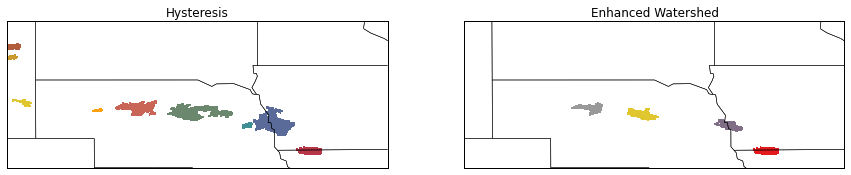

In [9]:
hyst = Hysteresis(5,25)
ew = EnhancedWatershed(5,5,100,100,10)
hyst_image = hyst.label(mesh_data[22])
ew_image = ew.label(mesh_data[22])
ew_image = ew.size_filter(ew_image, 100)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bmap.drawstates()
ht = plt.title("Hysteresis")
pcol = plt.pcolormesh(lon, lat, np.ma.array(hyst_image,mask=hyst_image < 1), vmin=1, cmap=plt.get_cmap('Set1', hyst_image.max()))
plt.subplot(1,2,2)
bmap.drawstates()
et = plt.title("Enhanced Watershed")
pcol = plt.pcolormesh(lon, lat, np.ma.array(ew_image, mask=ew_image < 1), vmin=1,cmap=plt.get_cmap('Set1', ew_image.max()))

#Hysteresis vs. Enhanced Watershed
* Hysteresis
    1. Only 2 parameters to set
    2. Captures entirety of regions
    3. Can combine seemingly distinct objects
* Enhanced Watershed
    1. Captures different scales depending on size threshold
    2. Captures core of objects
    3. Can separate even adjacent objects

#Solar Irradiance Prediction
* 